================================================================================
## Exploratory Data Analysis for the Air Quality Dataset - Part 2
### Correlation Analysis Between The Variables and Air Quality Index (AQI)
================================================================================

### What are the most Important Pollutants to Consider Based on Their Relevance to Air Quality Index (AQI)?
#### Methodology
1. Create a correlation matrix heatmap to identify the most highly correlated pollutants with AQI based on their correlation index
2. Create a scatterplot showing the relation of every pollutant concentration towards the AQI value
3. Calculate linear regression to determine the most relevant pollutant based on the coefficient of determination (R-squared), Pearson correlation coefficient, and p-value
4. Rank the pollutants based on their R-squared value, Pearson correlation coefficient, and p-value
5. Create new index values to determine the relative contribution of selected pollutant types to AQI values.
6. Visualize the results using a line graph to show the relative contribution of each selected indexes to the AQI scores over monthly time periods

================================================================================
#### Import Necessary Libraries, Functions and Datasets From The Previous Methodology Steps


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

df_station_hour = pd.read_csv(r'C:\Users\Lenovo\.cache\kagglehub\datasets\rohanrao\air-quality-data-in-india\versions\12\station_hour.csv')
df_stations = pd.read_csv(r'C:\Users\Lenovo\.cache\kagglehub\datasets\rohanrao\air-quality-data-in-india\versions\12\stations.csv')

df_station_hour = df_station_hour[df_station_hour['Datetime'].isna() == False]
df_cities = pd.merge(df_station_hour, df_stations, how = 'left', on = 'StationId')
df_cities = df_cities[df_cities['Status'] == 'Active']
df_cities['Datetime'] = pd.to_datetime(df_cities['Datetime'])

def remove_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR 
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df_city = df_cities.copy()
df_city.loc[:, 'PM2.5' : 'AQI'] = remove_outliers(df_city.loc[:, 'PM2.5' : 'AQI'])

### Create A Correlation Matrix Heatmap Showing The Pearson Correlation Index Between Each Pair of Variables

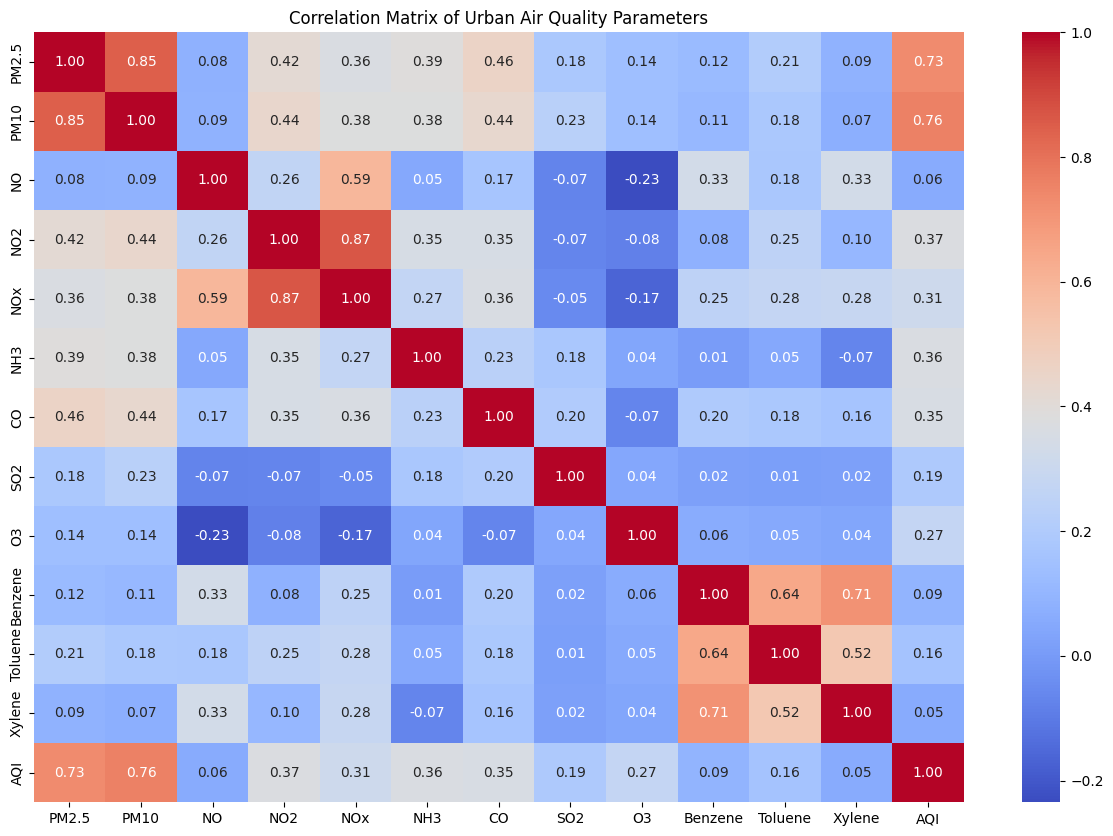

In [23]:
#Correlation matrix heatmap creation
data = df_city.loc[:, 'PM2.5' : 'AQI'].copy()
correlation_matrix = data.corr(method='spearman')

plt.figure(figsize = (15,10))
sns.heatmap(correlation_matrix, annot=True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix of Urban Air Quality Parameters')

plt.show()

### Create A Dataset Column That Shows Date in Day Metrics

In [24]:
# Creating a Date_Day Object Column on a Dataframe
df_city['Date_Day'] = df_city['Datetime'].dt.to_period('D')

datetime_index = df_city.columns.get_loc('Datetime')
df_city.insert(datetime_index + 1, 'Date_Day', df_city.pop('Date_Day'))

df_city['Date_Day'] = df_city['Date_Day'].astype('str')

### Create A Pivot Table Based on The Daily Averages of Airborne Pollutant Concentrations with columns of AQI categories added

In [25]:
# Create Pivot Table Accordingly to the AQI_Bucket Categories

def d_create_pivot(df_list):
    values = df_cities.loc[0:0, 'PM2.5':'AQI'].columns.to_list()
    bins = [5,50,100,200,300,400,5000]
    labels = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']

    bins2 = [5,100,5000]
    labels2 = ['Satisfactory','Unsatisfactory']

    pivot_list = []
    for i in range(len(df_list)):
        df_pivot = df_list[i].pivot_table(values = values, index='Date_Day', aggfunc='mean')
        df_pivot['AQI_Bucket'] = pd.cut(df_pivot['AQI'], bins=bins, labels=labels, right=False)
        df_pivot['Satisfactory_AQI'] = pd.cut(df_pivot['AQI'], bins=bins2, labels=labels2, right=False)
        df_pivot = df_pivot.reset_index()
        df_pivot.insert(1, 'AQI_Bucket', df_pivot.pop('AQI_Bucket'))
        df_pivot.insert(2, 'Satisfactory_AQI', df_pivot.pop('Satisfactory_AQI'))
        df_pivot.loc[:, 'AQI':] = df_pivot.loc[:, 'AQI':].fillna(0)
        pivot_list.append(df_pivot)

    return pivot_list


list_city =  []
list_city.append(df_city)
pivot_city_list = d_create_pivot(list_city)
df_c_pivot = pivot_city_list[0]

### Create Scatterplots Visualizing the Relationship Between Airborne Pollutant Concentration and Air Quality Index
- **Step 1**: Create a scatterplot of selected two variables
- **Step 2**: Add a regression line to the scatterplot to visualize the relationship between the two variables
- **Step 3**: Calculate the Pearson Correlation Coefficient, R-squared value, and p-value to quantify the strength and significance of the relationship between the two variables
- **Step 4**: Display calculated values next to the scatterplot in an independent table

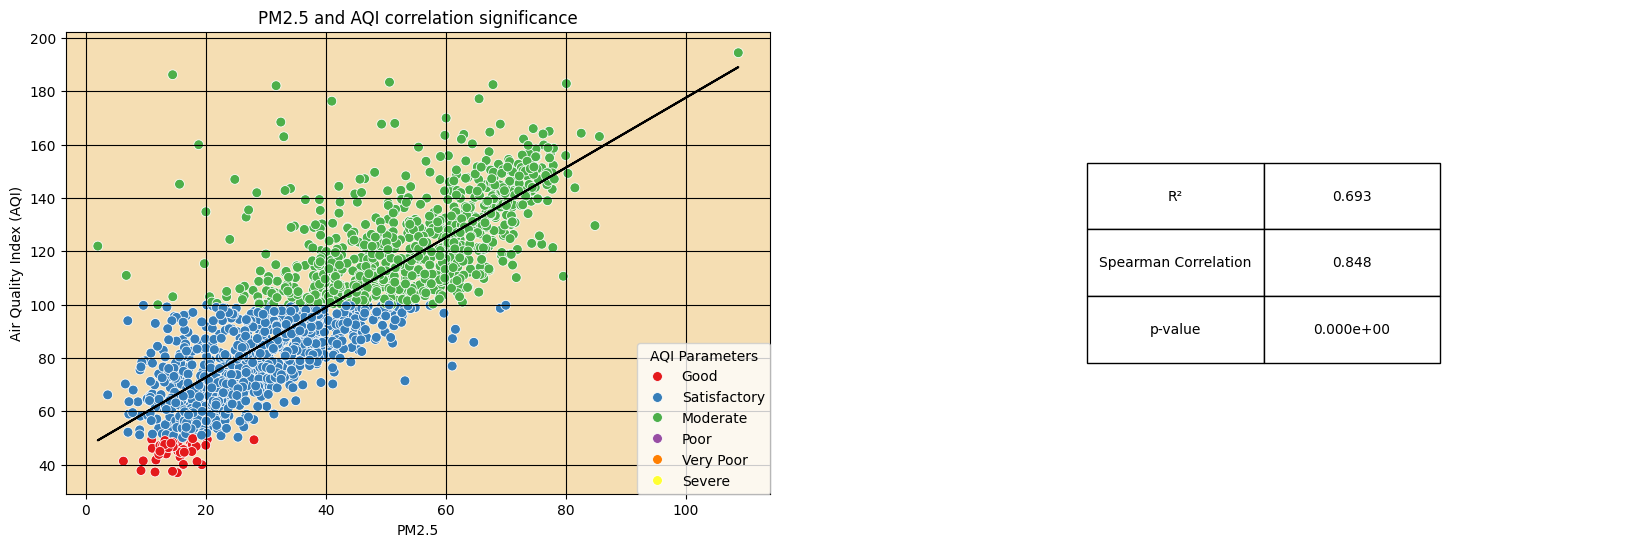

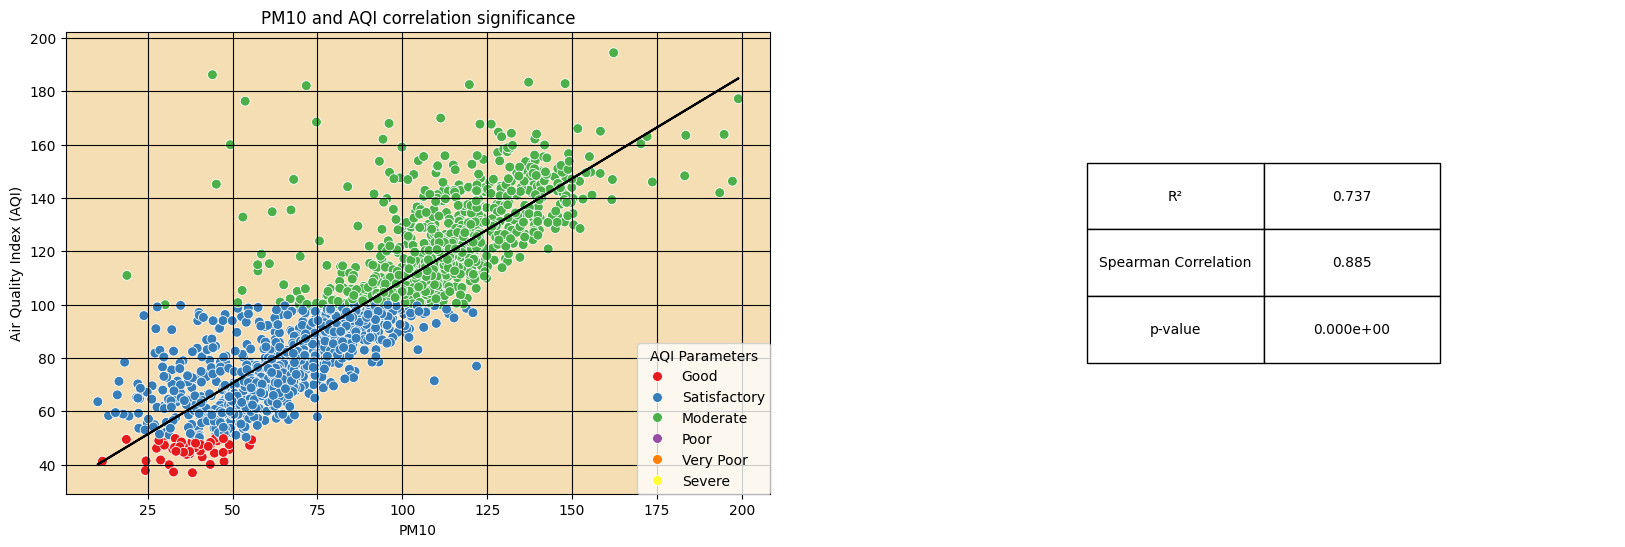

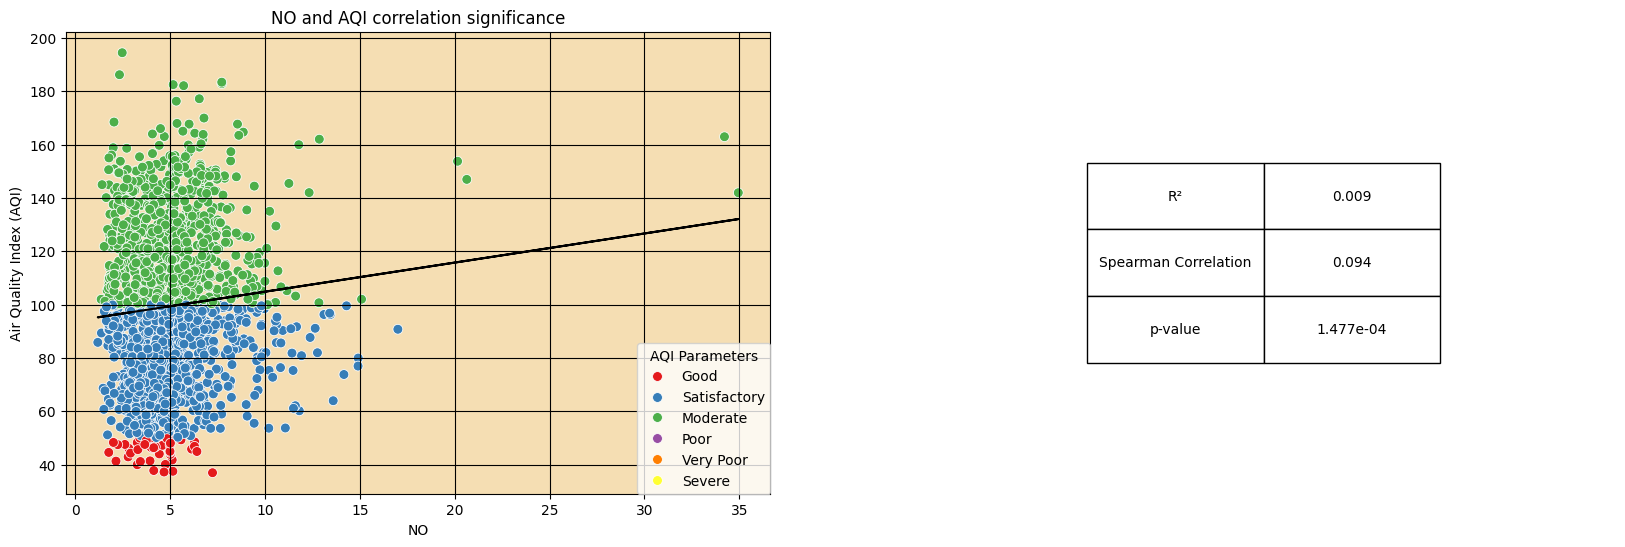

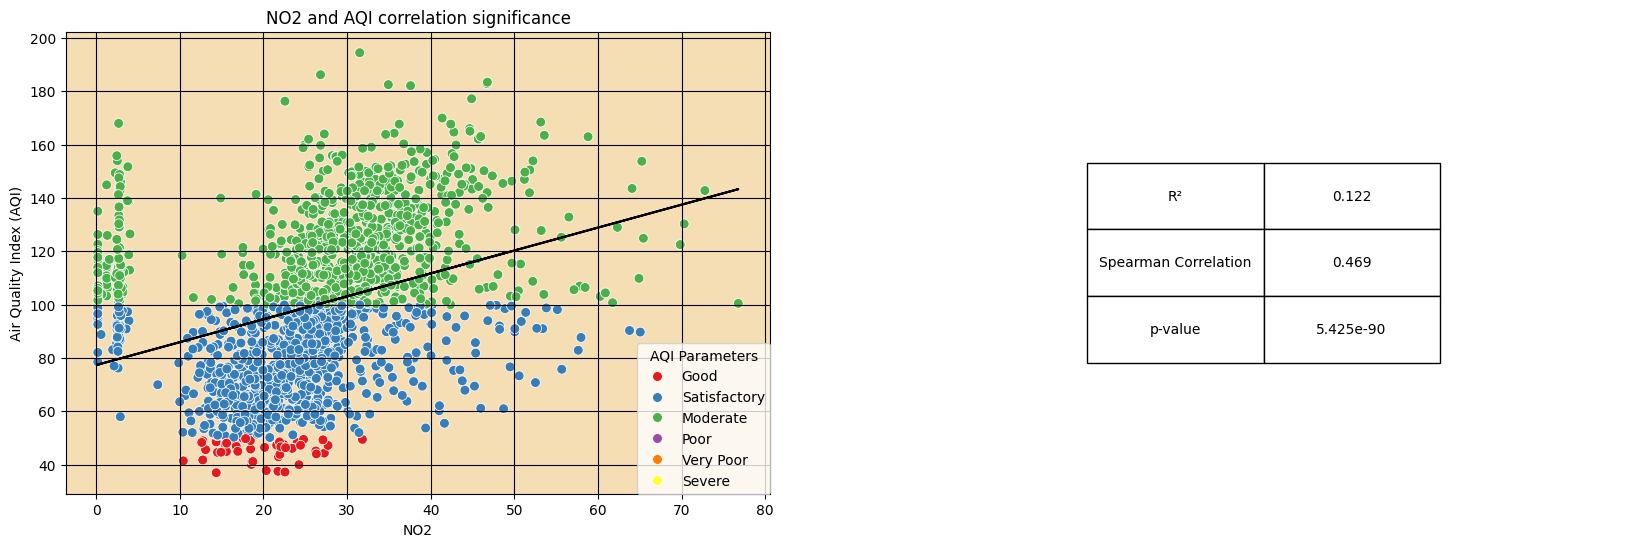

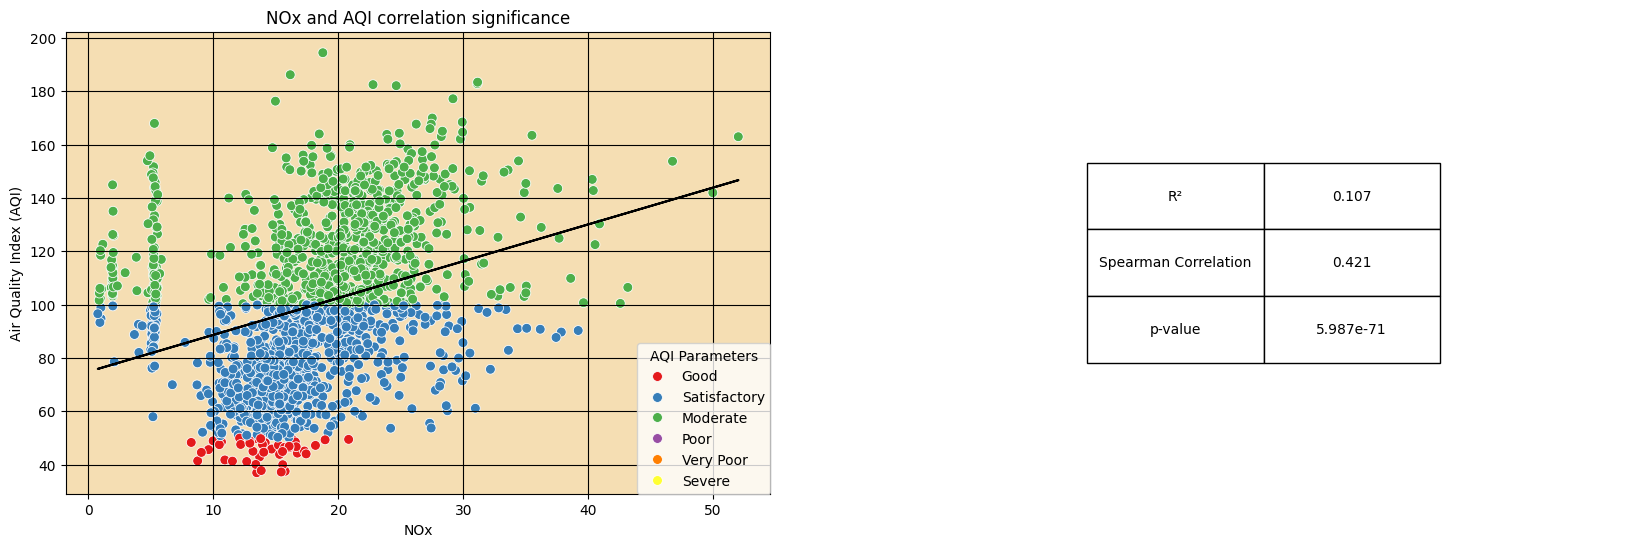

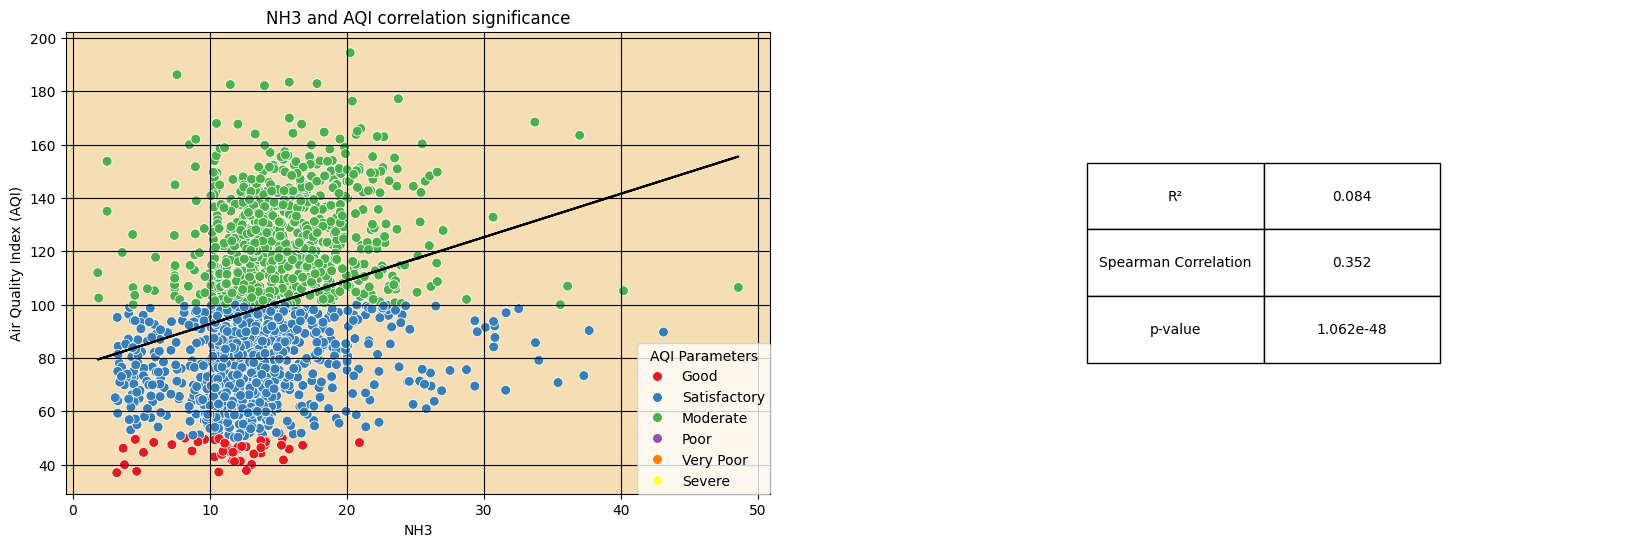

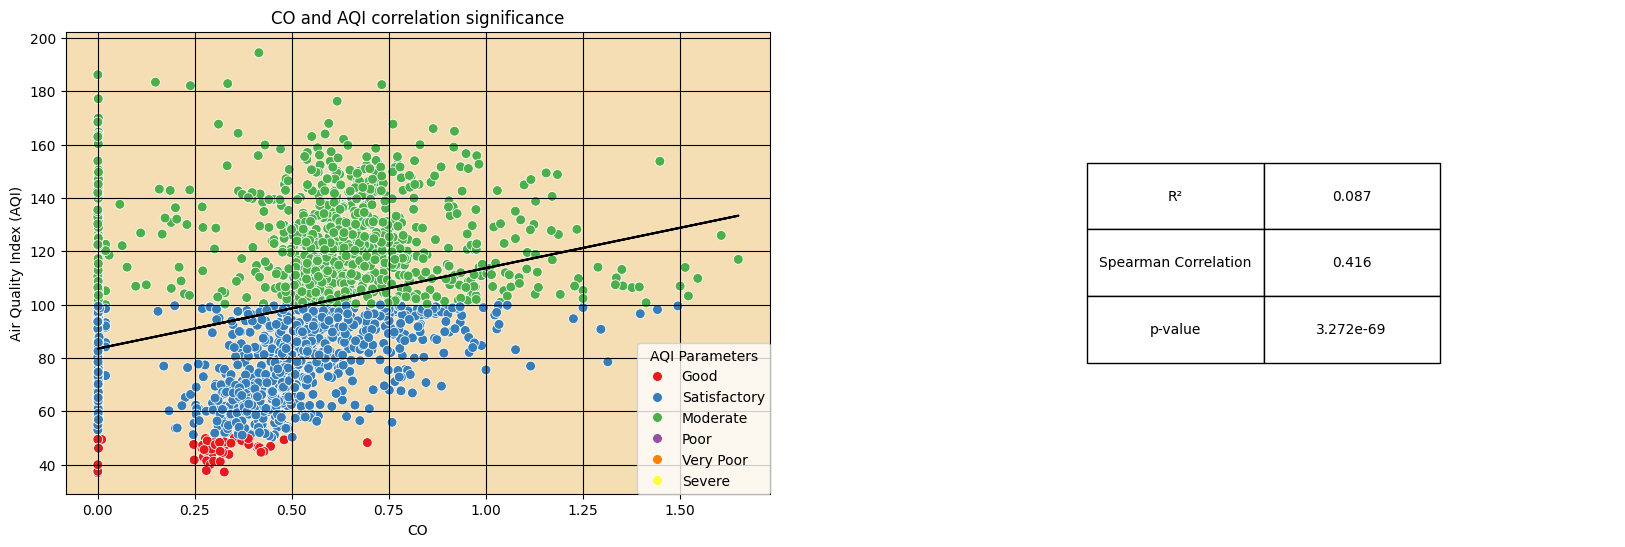

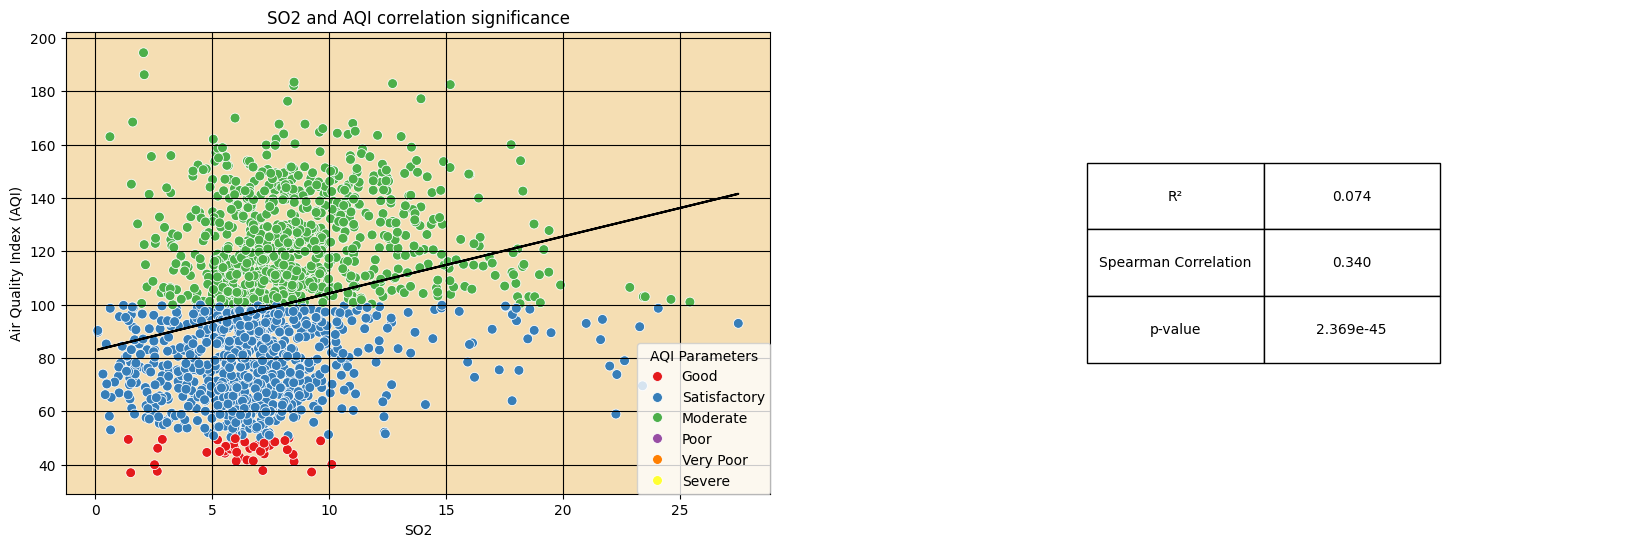

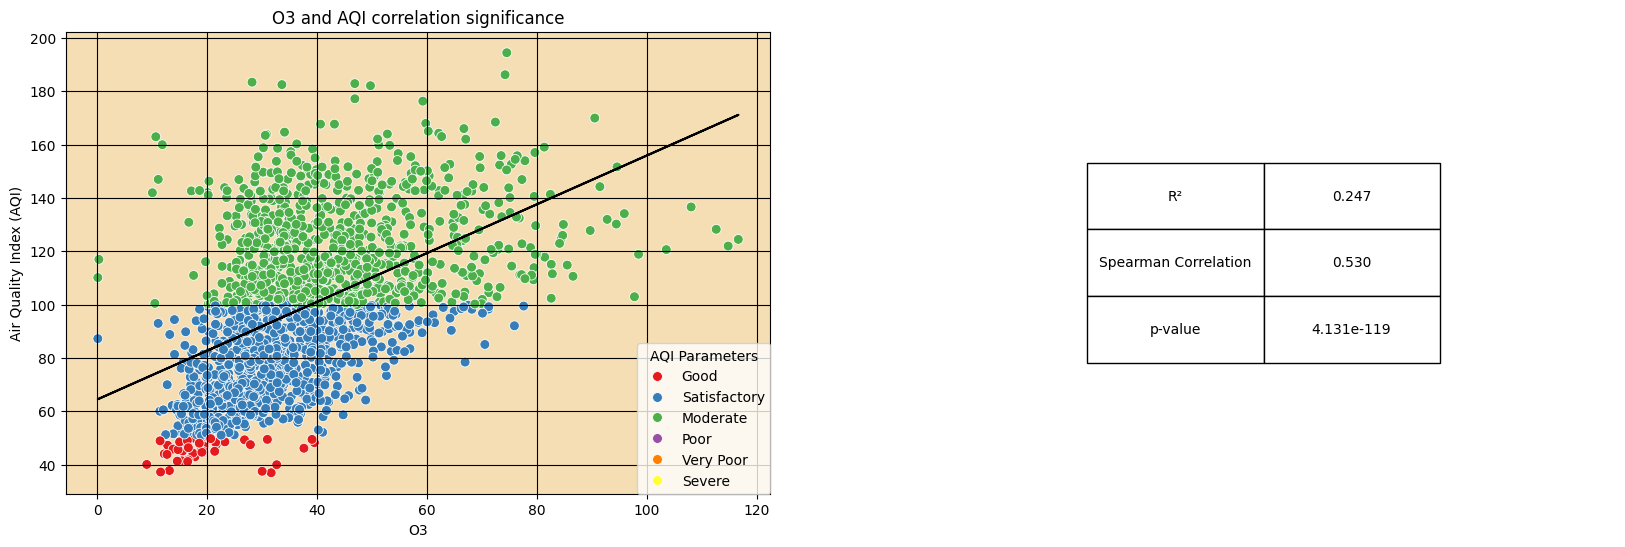

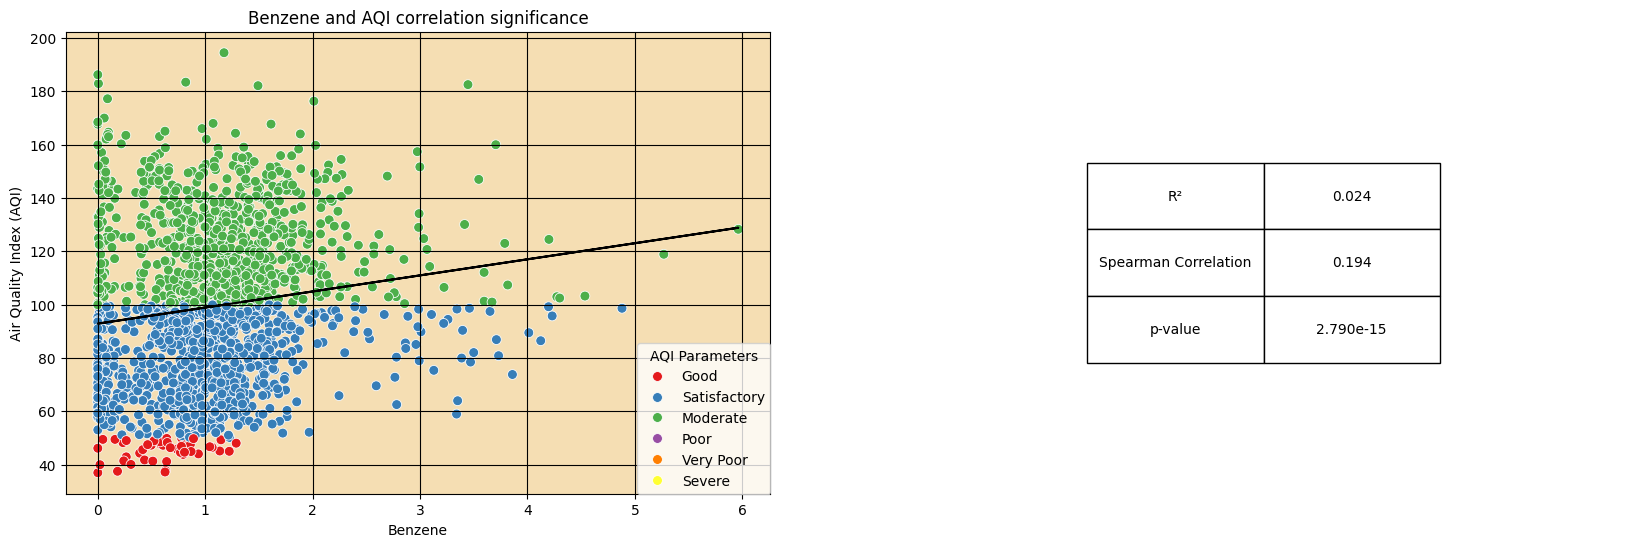

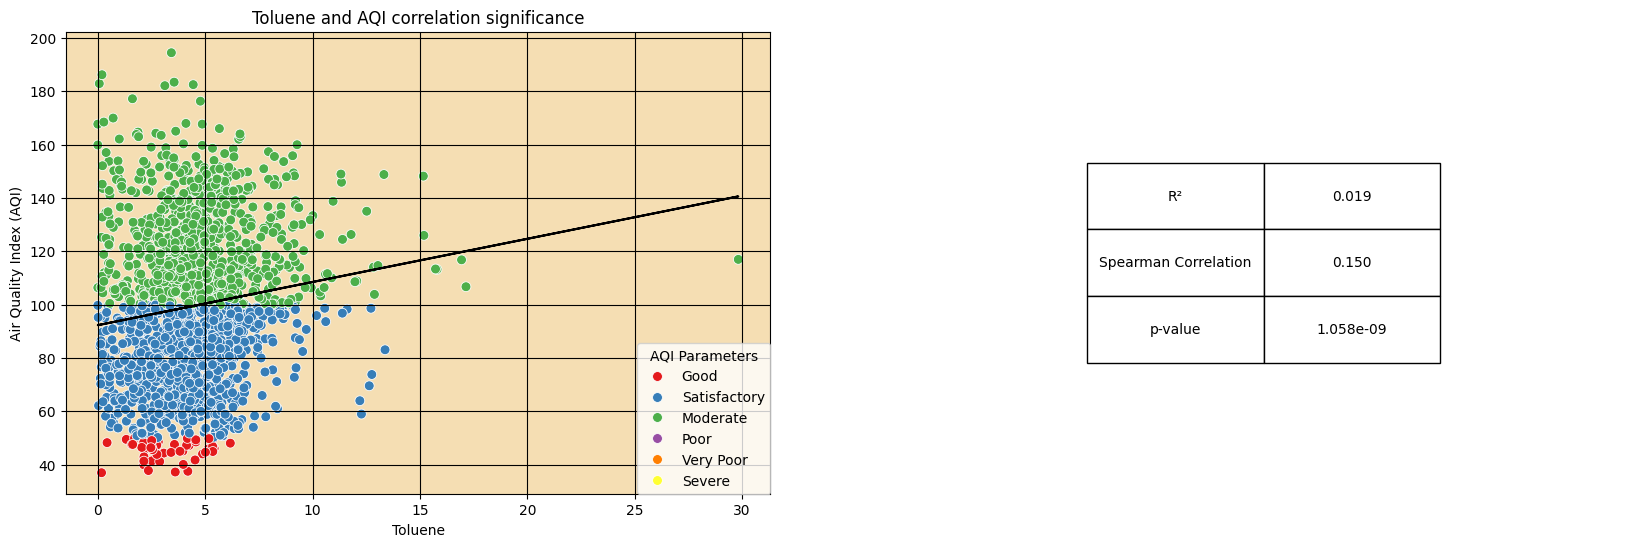

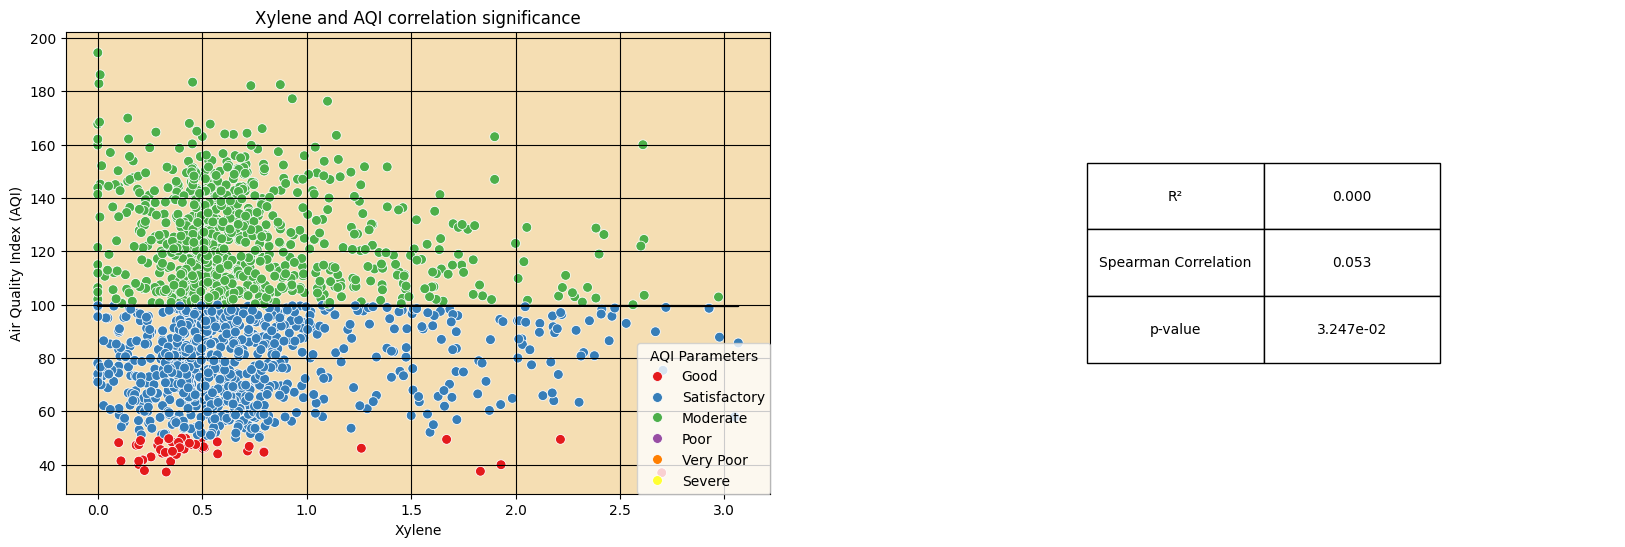

In [ ]:
# Creating Correlation Scatterplots of Each Selected Paramter of Contaminants towards  Air Quality Index
parameter_values = df_city.loc[0:0, 'PM2.5':'Xylene'].columns.to_list()

## Creating a looped segment to generate scatterplots for each parameter
for value in parameter_values:

##  Calculating the correlation coefficient and p-value between the parameter and AQI
    correlation_coefficient, p_value = stats.spearmanr(df_c_pivot[value], df_c_pivot['AQI'])

##  Creating the model of linear regression and calculating the coefficient of determination (R-squared)
    model = LinearRegression()
    X_reshaped = df_c_pivot[value].values.reshape(-1,1)
    model.fit(X_reshaped, df_c_pivot['AQI'])
    y_pred = model.predict(X_reshaped)
    r2 = r2_score(df_c_pivot['AQI'], y_pred)
##  Creating list of metrics data that will be displayed on the Table next to the Scatterplot
    metrics_data = [
        ['R²', f'{r2:.3f}'],
        ['Spearman Correlation', f'{correlation_coefficient:.3f}'],
        ['p-value', f'{p_value:.3e}']
    ]

##  Creating a Scatterplot with Regression Line and Added Table with Metrics
    fig, (ax, ax2) = plt.subplots(1,2, figsize=(20,6))

    scatter = sns.scatterplot(data=df_c_pivot, x=value, y='AQI', hue='AQI_Bucket', palette='Set1', s=50, ax = ax)
    slope, intercept = np.polyfit(df_c_pivot[value], df_c_pivot['AQI'], 1)
    regression_line = slope * df_c_pivot[value] + intercept

    ax.plot(df_c_pivot[value], regression_line, color='black')

    ax.set_xlabel(value)
    ax.set_title(f'{value} and AQI correlation significance')
    ax.set_ylabel('Air Quality Index (AQI)')
    ax.set_facecolor('#F5DEB3')
    ax.legend(title='AQI Parameters', loc='lower right', bbox_to_anchor=(1, 0), borderaxespad=0.)
    ax.grid(color='black')

### Create the table
    table = ax2.table(cellText=metrics_data, loc='center', cellLoc='center')
    ax2.axis('off')

    table.auto_set_font_size(False)  
    table.set_fontsize(10)  
    table.scale(0.5, 4) 

##  Showing the plot
    plt.show()

### Create Indexes Displaying the Sum of Selected Pollutant Concentration Values Multiplied by their Respective Correlation Coefficients With the AQI

In [27]:
# Creating Index Values of Selected Parameters in the DataFrame

def all_indexes(pivot_list):
    aqi_correlations = correlation_matrix['AQI']
    correlations_aqi = list(float (x) for x in aqi_correlations.values[:-1])
    params_aqi = list(aqi_correlations.index[:-1])
    for i in range(len(pivot_list)):
        pivot_list[i]['Weighted Sum Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)

    correlations_aqi = list(float (x) for x in aqi_correlations.values[:2])
    params_aqi = list(aqi_correlations.index[:2])
    for i in range(len(pivot_list)):
        pivot_list[i]['Particulate Matter Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)

    correlations_aqi = list(float (x) for x in aqi_correlations.values[2:6])
    params_aqi = list(aqi_correlations.index[2:6])
    for i in range(len(pivot_list)):
        pivot_list[i]['Nitrogen Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)
    
    correlations_aqi = list(float (x) for x in aqi_correlations.values[6:9])
    params_aqi = list(aqi_correlations.index[6:9])
    for i in range(len(pivot_list)):
        pivot_list[i]['Oxydative Gases Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)

    correlations_aqi = list(float (x) for x in aqi_correlations.values[9:-1])
    params_aqi = list(aqi_correlations.index[9:-1])
    for i in range(len(pivot_list)):
        pivot_list[i]['Volatile Organic Compounds (BTX) Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)
    return pivot_list

list_c = []
list_c.append(df_c_pivot)
list_c = all_indexes(list_c)


### Create Scatterplots Showing The Relationship Between Each Selected Index and AQI

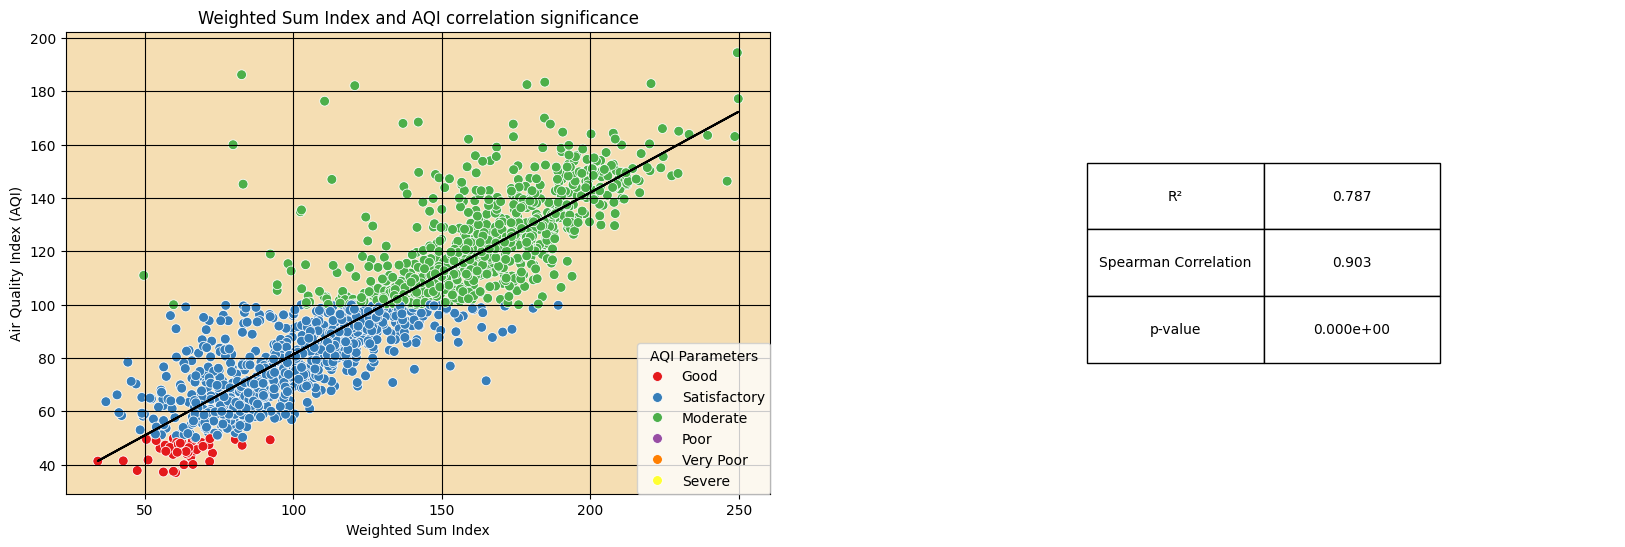

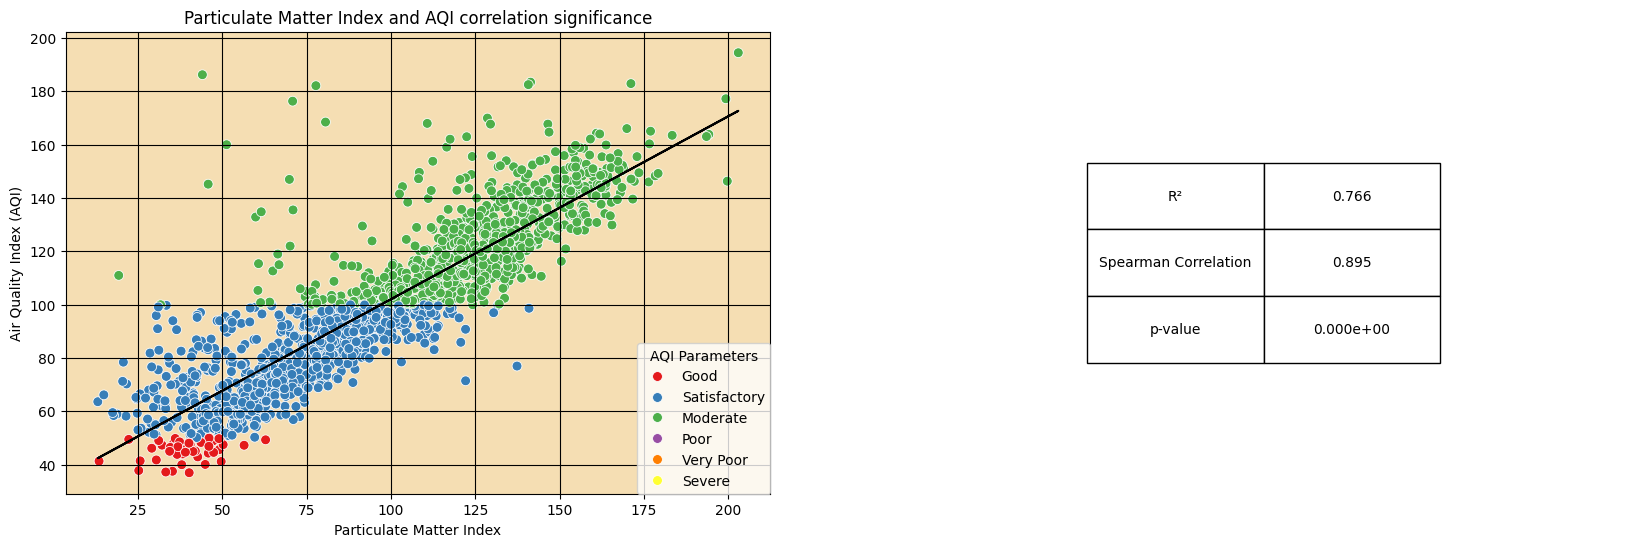

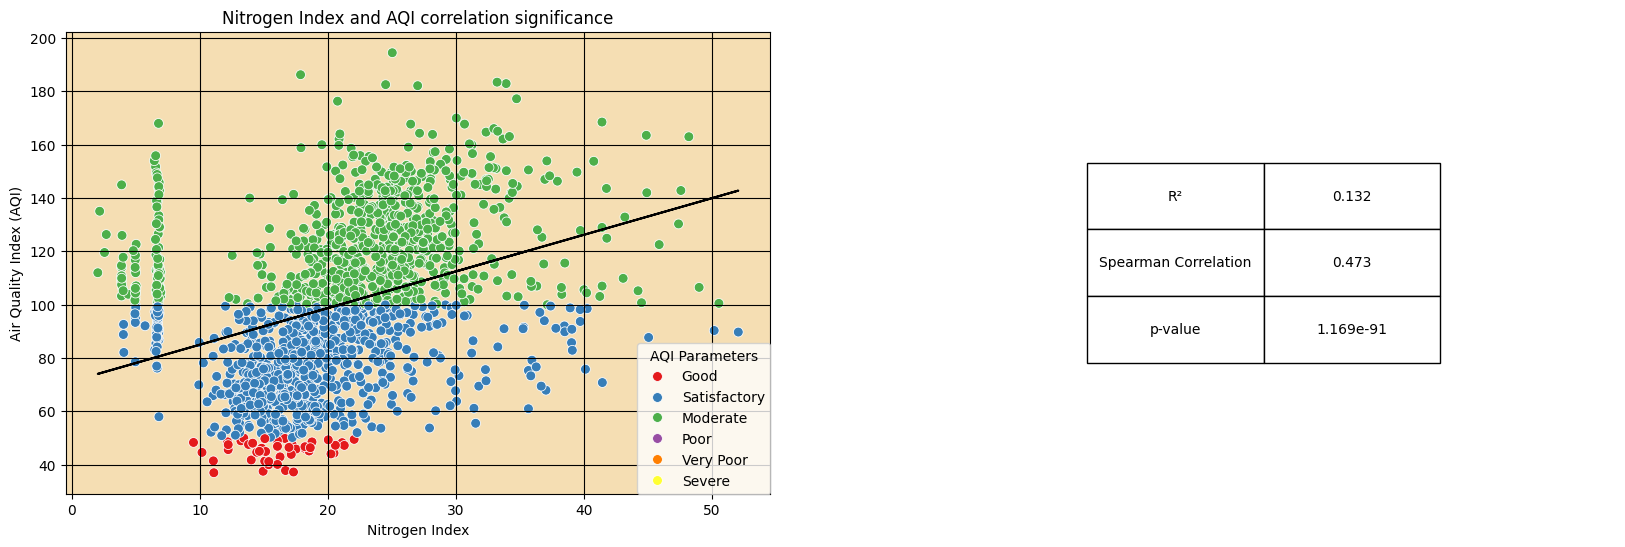

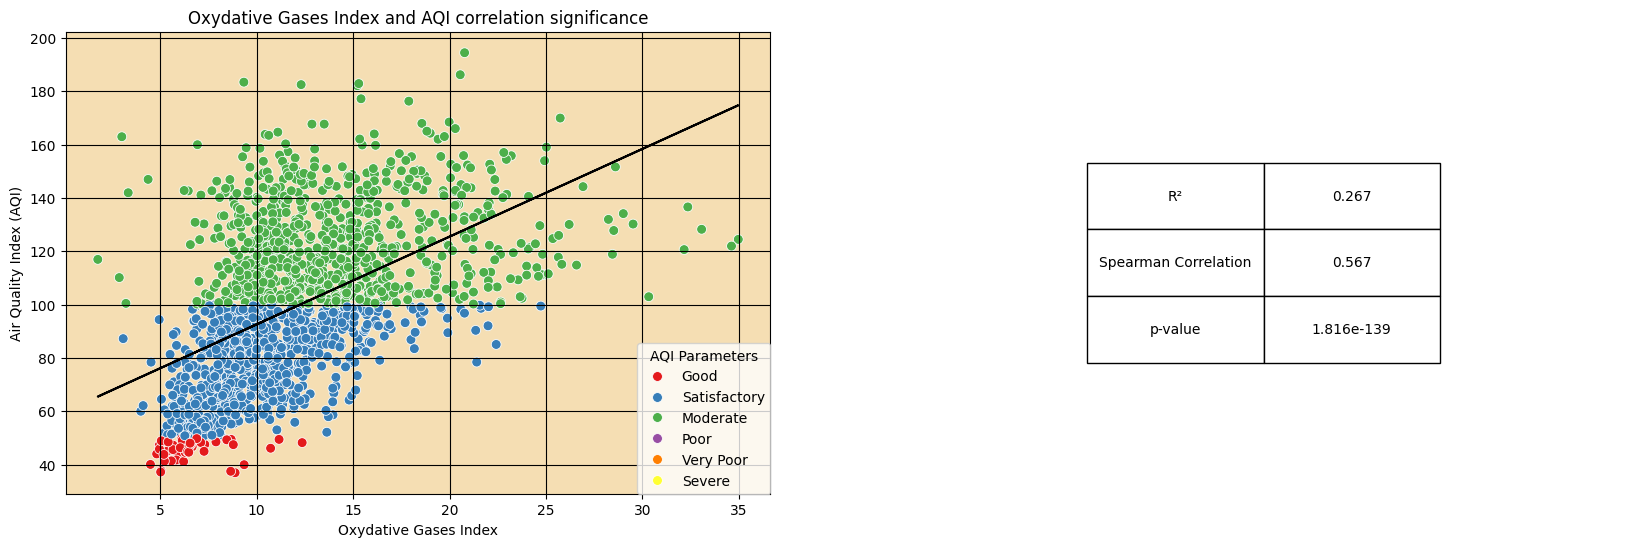

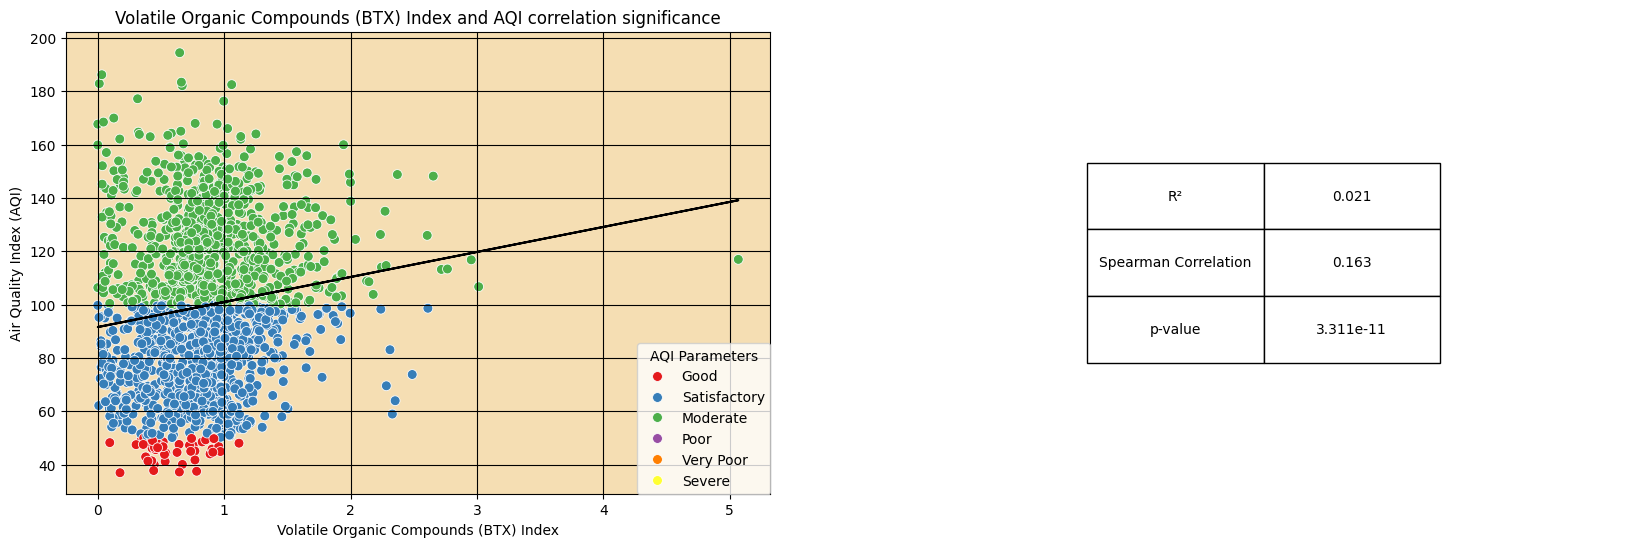

In [28]:
#Creating Correlation Scatterplots for Indexes of Selected Parameters

index_values = df_c_pivot.loc[0:0, 'Weighted Sum Index':]

for value in index_values:

    fig, (ax, ax2) = plt.subplots(1,2, figsize=(20,6))

    correlation_coefficient, p_value = stats.spearmanr(df_c_pivot[value], df_c_pivot['AQI'])

    model = LinearRegression()
    X_reshaped = df_c_pivot[value].values.reshape(-1,1)
    model.fit(X_reshaped, df_c_pivot['AQI'])
    y_pred = model.predict(X_reshaped)
    r2 = r2_score(df_c_pivot['AQI'], y_pred)

    

    scatter = sns.scatterplot(data=df_c_pivot, x=value, y='AQI', hue='AQI_Bucket', palette='Set1', s=50, ax = ax)
    slope, intercept = np.polyfit(df_c_pivot[value], df_c_pivot['AQI'], 1)
    regression_line = slope * df_c_pivot[value] + intercept
    ax.plot(df_c_pivot[value], regression_line, color='black')

    ax.set_xlabel(value)
    ax.set_title(f'{value} and AQI correlation significance')
    ax.set_ylabel('Air Quality Index (AQI)')
    ax.set_facecolor('#F5DEB3')
    ax.legend(title='AQI Parameters', loc='lower right', bbox_to_anchor=(1, 0), borderaxespad=0.)
    ax.grid(color='black')

    metrics_data = [
        ['R²', f'{r2:.3f}'],
        ['Spearman Correlation', f'{correlation_coefficient:.3f}'],
        ['p-value', f'{p_value:.3e}']
    ]

# Create the table
    table = ax2.table(cellText=metrics_data, loc='center', cellLoc='center')
    ax2.axis('off')
    ax2.axis('off')

    table.auto_set_font_size(False)  
    table.set_fontsize(10)  
    table.scale(0.5, 4) 

# Show the plot
    plt.show()

### Create A Dataset Column That Shows Date in Month Metrics

In [29]:
# Creating a Date_Month Object Column on a Dataframe

df_city['Date_Month'] = df_city['Datetime'].dt.to_period('M')

datetime_index = df_city.columns.get_loc('Datetime')
df_city.insert(datetime_index + 1, 'Date_Month', df_city.pop('Date_Month'))

df_city['Date_Month'] = df_city['Date_Month'].astype('str')
df_city['Date_Month'] = pd.to_datetime(df_city['Date_Month'])

df_city

StationId            Datetime Date_Month    Date_Day  PM2.5  PM10  NO  \
0           AP001 2017-11-24 17:00:00 2017-11-01  2017-11-24    NaN   NaN NaN   
1           AP001 2017-11-24 18:00:00 2017-11-01  2017-11-24    NaN   NaN NaN   
2           AP001 2017-11-24 19:00:00 2017-11-01  2017-11-24    NaN   NaN NaN   
3           AP001 2017-11-24 20:00:00 2017-11-01  2017-11-24    NaN   NaN NaN   
4           AP001 2017-11-24 21:00:00 2017-11-01  2017-11-24    NaN   NaN NaN   
...           ...                 ...        ...         ...    ...   ...  ..   
2589078     WB013 2020-06-30 20:00:00 2020-06-01  2020-06-30    NaN   NaN NaN   
2589079     WB013 2020-06-30 21:00:00 2020-06-01  2020-06-30    NaN   NaN NaN   
2589080     WB013 2020-06-30 22:00:00 2020-06-01  2020-06-30    NaN   NaN NaN   
2589081     WB013 2020-06-30 23:00:00 2020-06-01  2020-06-30    NaN   NaN NaN   
2589082     WB013 2020-07-01 00:00:00 2020-07-01  2020-07-01    NaN   NaN NaN   

         NO2  NOx  NH3  ...  O3  Benzene  Toluene  Xylene  AQI    AQI_Bucket  \
0        NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN           NaN   
1        NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN           NaN   
2        NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN           NaN   
3        NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN           NaN   
4        NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN           NaN   
...      ...  ...  ...  ...  ..      ...      ...     ...  ...           ...   
2589078  NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN  Satisfactory   
2589079  NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN  Satisfactory   
2589080  NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN  Satisfactory   
2589081  NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN  Satisfactory   
2589082  NaN  NaN  NaN  ... NaN      NaN      NaN     NaN  NaN  Satisfactory   

                            StationName       City           State  Status  
0        Secretariat, Amaravati - APPCB  Amaravati  Andhra Pradesh  Active  
1        Secretariat, Amaravati - APPCB  Amaravati  Andhra Pradesh  Active  
2        Secretariat, Amaravati - APPCB  Amaravati  Andhra Pradesh  Active  
3        Secretariat, Amaravati - APPCB  Amaravati  Andhra Pradesh  Active  
4        Secretariat, Amaravati - APPCB  Amaravati  Andhra Pradesh  Active  
...                                 ...        ...             ...     ...  
2589078       Victoria, Kolkata - WBPCB    Kolkata     West Bengal  Active  
2589079       Victoria, Kolkata - WBPCB    Kolkata     West Bengal  Active  
2589080       Victoria, Kolkata - WBPCB    Kolkata     West Bengal  Active  
2589081       Victoria, Kolkata - WBPCB    Kolkata     West Bengal  Active  
2589082       Victoria, Kolkata - WBPCB    Kolkata     West Bengal  Active  

[2542823 rows x 22 columns]

### Create A Pivot Table Based on The Monthly Averages of Airborne Pollutant Concentrations with columns of AQI categories added

In [30]:
#Create Pivot Table Accordingly to the AQI_Bucket Categories

def m_create_pivot(df_list):
    values = df_cities.loc[0:0, 'PM2.5':'AQI'].columns.to_list()
    bins = [5,50,100,200,300,400,5000]
    labels = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']

    bins2 = [5,100,5000]
    labels2 = ['Satisfactory','Unsatisfactory']

    pivot_list = []
    for i in range(len(df_list)):
        df_pivot = df_list[i].pivot_table(values = values, index='Date_Month', aggfunc='mean')
        df_pivot['AQI_Bucket'] = pd.cut(df_pivot['AQI'], bins=bins, labels=labels, right=False)
        df_pivot['Satisfactory_AQI'] = pd.cut(df_pivot['AQI'], bins=bins2, labels=labels2, right=False)
        df_pivot = df_pivot.reset_index()
        df_pivot.insert(1, 'AQI_Bucket', df_pivot.pop('AQI_Bucket'))
        df_pivot.insert(2, 'Satisfactory_AQI', df_pivot.pop('Satisfactory_AQI'))
        df_pivot.loc[:, 'AQI':] = df_pivot.loc[:, 'AQI':].fillna(0)
        pivot_list.append(df_pivot)

    return pivot_list

l_m = []
l_m.append(df_city)
l_m = m_create_pivot(l_m)
l_m = all_indexes(l_m)
m_c_pivot = l_m[0]
m_c_pivot

Date_Month    AQI_Bucket Satisfactory_AQI         AQI   Benzene        CO  \
0  2015-09-01  Satisfactory     Satisfactory   63.389474  0.645000  0.608789   
1  2015-10-01      Moderate   Unsatisfactory  107.070652  1.398016  1.020163   
2  2015-11-01      Moderate   Unsatisfactory  111.044990  1.658262  0.882945   
3  2015-12-01  Satisfactory     Satisfactory   98.441423  1.646967  0.816883   
4  2016-01-01      Moderate   Unsatisfactory  132.502203  1.716740  0.985507   
5  2016-02-01  Satisfactory     Satisfactory   97.032710  1.201869  0.762570   
6  2016-03-01      Moderate   Unsatisfactory  103.449244  1.252289  0.800648   
7  2016-04-01  Satisfactory     Satisfactory   96.373650  0.795810  0.635853   
8  2016-05-01  Satisfactory     Satisfactory   76.148423  0.349518  0.558145   
9  2016-07-01  Satisfactory     Satisfactory   93.472222  3.372014  0.836875   
10 2016-08-01  Satisfactory     Satisfactory   82.940120  2.628982  0.572216   
11 2016-09-01  Satisfactory     Satisfactory   74.861538  1.710692  0.519846   
12 2016-10-01  Satisfactory     Satisfactory   84.287206  0.989034  0.565300   
13 2016-11-01      Moderate   Unsatisfactory  119.090909  1.722652  0.867702   
14 2016-12-01      Moderate   Unsatisfactory  115.083538  1.565676  0.906093   
15 2017-01-01      Moderate   Unsatisfactory  131.601100  0.872682  0.409986   
16 2017-02-01      Moderate   Unsatisfactory  145.325744  1.179072  0.372259   
17 2017-03-01      Moderate   Unsatisfactory  114.099394  1.187903  0.251952   
18 2017-04-01      Moderate   Unsatisfactory  129.399642  0.547330  0.161541   
19 2017-05-01  Satisfactory     Satisfactory   99.658098  0.021157  0.000925   
20 2017-06-01  Satisfactory     Satisfactory   86.176587  0.061429  0.000734   
21 2017-07-01  Satisfactory     Satisfactory   75.760814  0.016132  0.000611   
22 2017-08-01  Satisfactory     Satisfactory   74.480818  0.183862  0.000844   
23 2017-09-01  Satisfactory     Satisfactory   70.977654  0.168920  0.000931   
24 2017-10-01      Moderate   Unsatisfactory  114.879357  0.959732  0.538874   
25 2017-11-01      Moderate   Unsatisfactory  107.806417  1.138733  0.645551   
26 2017-12-01      Moderate   Unsatisfactory  133.647963  1.030873  0.696297   
27 2018-01-01      Moderate   Unsatisfactory  141.991823  0.628622  0.668508   
28 2018-02-01      Moderate   Unsatisfactory  116.079439  0.691785  0.672780   
29 2018-03-01      Moderate   Unsatisfactory  110.588554  1.160512  0.772886   
30 2018-04-01  Satisfactory     Satisfactory   91.582800  0.827822  0.597704   
31 2018-05-01  Satisfactory     Satisfactory   95.098277  0.875105  0.599920   
32 2018-06-01  Satisfactory     Satisfactory   68.599205  0.684550  0.508782   
33 2018-07-01  Satisfactory     Satisfactory   63.415612  0.837297  0.304949   
34 2018-08-01  Satisfactory     Satisfactory   60.515436  0.673490  0.314330   
35 2018-09-01  Satisfactory     Satisfactory   83.939428  1.024093  0.452381   
36 2018-10-01      Moderate   Unsatisfactory  114.078734  1.233494  0.500593   
37 2018-11-01      Moderate   Unsatisfactory  102.723139  1.256310  0.548926   
38 2018-12-01      Moderate   Unsatisfactory  129.300529  1.328906  0.610281   
39 2019-01-01      Moderate   Unsatisfactory  130.073961  1.187991  0.616805   
40 2019-02-01      Moderate   Unsatisfactory  116.412774  0.975764  0.577405   
41 2019-03-01      Moderate   Unsatisfactory  108.869771  1.241376  0.582749   
42 2019-04-01  Satisfactory     Satisfactory   99.272865  1.255121  0.545454   
43 2019-05-01      Moderate   Unsatisfactory  118.337361  1.165487  0.542606   
44 2019-06-01  Satisfactory     Satisfactory   79.648268  0.801946  0.418924   
45 2019-07-01  Satisfactory     Satisfactory   62.882585  0.964176  0.408207   
46 2019-08-01  Satisfactory     Satisfactory   61.111787  0.947106  0.443281   
47 2019-09-01  Satisfactory     Satisfactory   59.899880  0.977298  0.470072   
48 2019-10-01  Satisfactory     Satisfactory   81.048607  1.375908  0.514336   
49 

### Timely Display of Average Index Value Distribution on a Monthly Basis in all Regions and Compared to Monthly AQI Averages

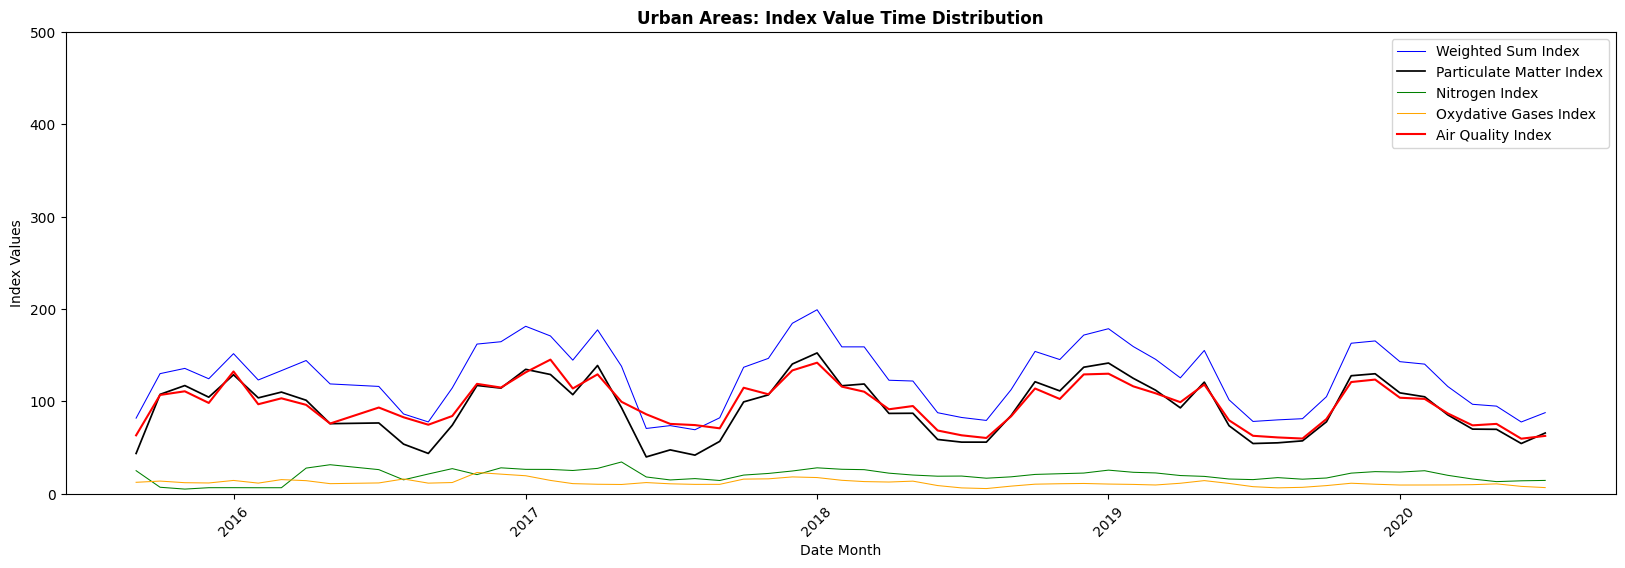

In [31]:
#AQI and WSI Monthly Distribution in Cities and Urban Areas

fig, ax = plt.subplots(figsize=(20,6))

ax.set_title('Urban Areas: Index Value Time Distribution', weight='bold')
ax.set_xlabel('Date Month')
ax.set_ylabel('Index Values') 
ax.tick_params(axis = 'x', rotation=45)
sns.lineplot(x='Date_Month', y='Weighted Sum Index', color = 'blue', data=m_c_pivot, ax=ax, linewidth = 0.75, label = 'Weighted Sum Index')
sns.lineplot(x='Date_Month', y='Particulate Matter Index', color = 'black', data=m_c_pivot, ax=ax,linewidth = 1.25, label = 'Particulate Matter Index')
sns.lineplot(x='Date_Month', y='Nitrogen Index', color = 'green',  data=m_c_pivot, ax=ax,linewidth = 0.75, label = 'Nitrogen Index')
sns.lineplot(x='Date_Month', y='Oxydative Gases Index', color = 'orange', data=m_c_pivot, ax=ax,linewidth = 0.75, label = 'Oxydative Gases Index')
sns.lineplot(x='Date_Month', y='AQI', color = 'red', data=m_c_pivot, ax=ax,linewidth = 1.5, label = 'Air Quality Index')


ax.set_ylim(0,500)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.legend()
plt.show()